### Modeling
This project will be using xgboost to identify risk factors

In [44]:
# Data Science Libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import brier_score_loss

import joblib

In [3]:
df = pd.read_csv('..\data\df.csv') #Read in data

In [4]:
# Features for Farmingham risk factor. These will be the predictor labels
features = [ 'age', 'total_chol', 'hdl_chol', 'sbp', 'bp_treated', 'smoker', 'diabetes']
x = df[features]
y = df['high_risk'] # Target variable. If someone is at high risk or not

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 42, stratify=y)

In [9]:
model = xgb.XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    use_label_encoder = False,
    eval_metric = 'logloss'
)

model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [10]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:,1]

print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        88
           1       0.88      0.89      0.88       141

    accuracy                           0.86       229
   macro avg       0.85      0.85      0.85       229
weighted avg       0.86      0.86      0.86       229

AUC: 0.931


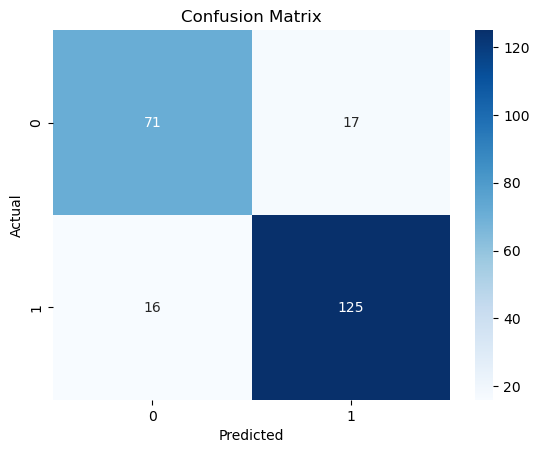

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

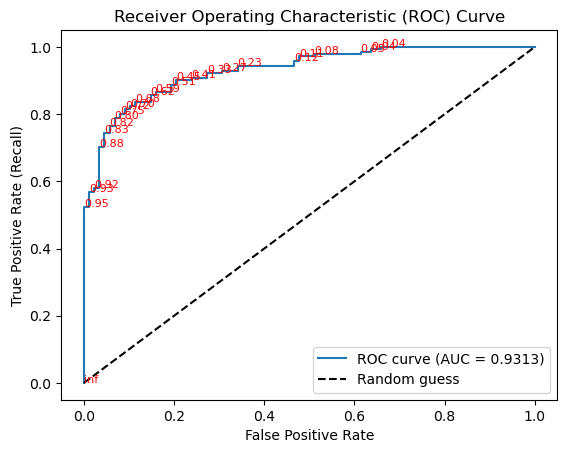

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under Curve)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label = f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random guess')
# Add threshold markers
for i in range(0, len(thresholds), max(len(thresholds)//20,1)):  # Plot every ~20th point
    plt.text(fpr[i], tpr[i], f'{thresholds[i]:.2f}', fontsize=8, color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc ='lower right')
plt.show()

In [ ]:
def threshold_curve(test, prob, target_recall):
    """
    Plot precision-recall curve and calculate best threshold for target recall.
    
    Parameters:
    - test: target var testing values
    - prob: predicted probabilities
    - target_recall: target recall

    Returns:
    - chosen_threshold: chosen threshold value
    """
    # Get precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(test, prob)

    # Plot Recall vs Threshold
    plt.plot(thresholds, recall[:-1], label = 'Recall', color = 'blue')
    plt.plot(thresholds, precision[:-1], label = 'Precision', color = 'green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Recall and Precision vs Threshold')
    plt.legend()
    plt.show()

    # Identify best threshold value
    idx = np.where(recall[:-1] >= target_recall)[0]
    if len(idx) > 0:
        chosen_threshold = thresholds[idx[-1]]  # pick highest threshold with recall >= target
        print(f"Chosen threshold for Recall >= {target_recall}: {chosen_threshold:.2f}")
    else:
        print("No threshold found with that Recall level.")
    
    return chosen_threshold

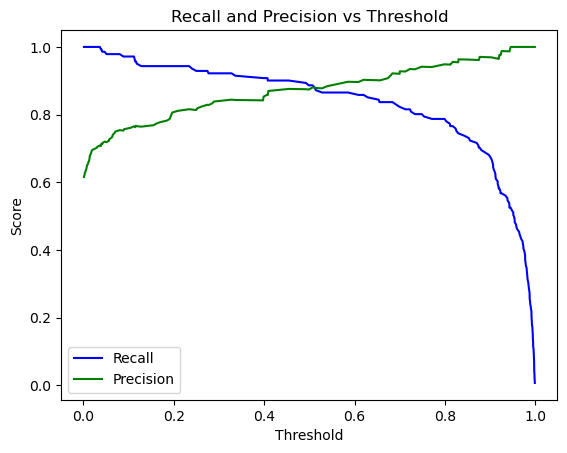

Chosen threshold for Recall >= 0.9: 0.45


In [31]:
chosen_threshold = threshold_curve(y_test, y_prob, target_recall=0.9)

In [32]:
# Apply chosen threshold to probabilities
y_pred_custom = (y_prob >= chosen_threshold).astype(int)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        88
           1       0.88      0.90      0.89       141

    accuracy                           0.86       229
   macro avg       0.85      0.85      0.85       229
weighted avg       0.86      0.86      0.86       229



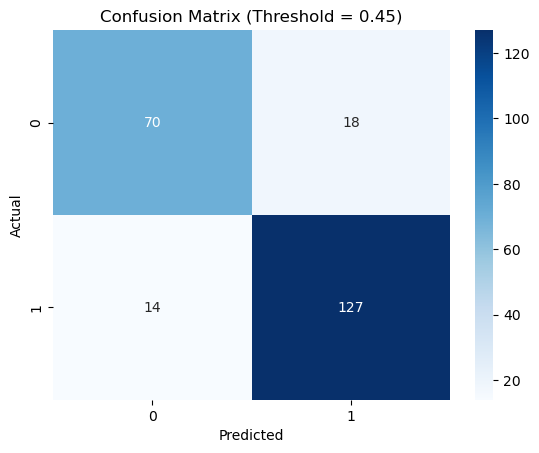

AUC: 0.9313


In [33]:
# Classification report
print(classification_report(y_test, y_pred_custom))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {chosen_threshold:.2f})')
plt.show()

# AUC (same as before, threshold-independent)
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

In [ ]:
# Grid search tuning
# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(x_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC: 0.9406996768283857


In [42]:
best_model = grid_search.best_estimator_
y_probs = best_model.predict_proba(x_test)[:, 1]

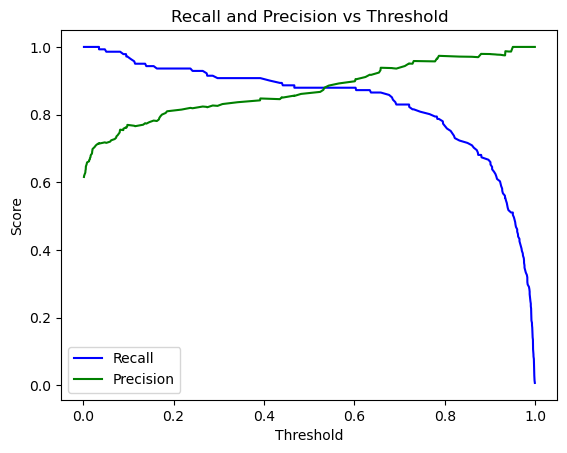

Chosen threshold for Recall >= 0.9: 0.41
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        88
           1       0.85      0.90      0.87       141

    accuracy                           0.84       229
   macro avg       0.83      0.82      0.83       229
weighted avg       0.84      0.84      0.84       229



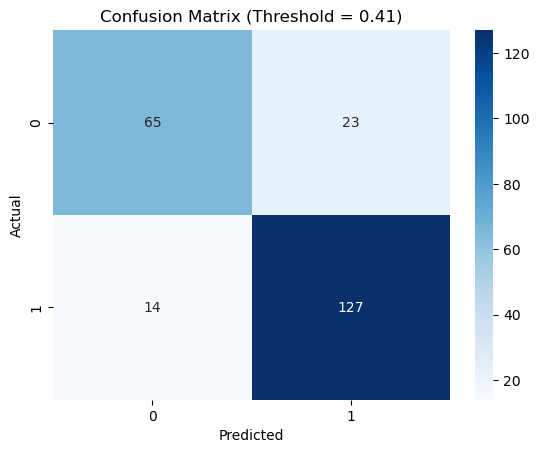

AUC: 0.9371


In [43]:
chosen_threshold = threshold_curve(y_test, y_probs, target_recall=0.9)


y_preds_custom = (y_probs >= chosen_threshold).astype(int)

print(classification_report(y_test, y_preds_custom))

cm = confusion_matrix(y_test, y_preds_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {chosen_threshold:.2f})')
plt.show()

auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc:.4f}")


In [48]:
joblib.dump(model, '..\model\\xgb_model.joblib')
joblib.dump(best_model, '..\model\\xgb_best_model.joblib')

['..\\model\\xgb_best_model.joblib']